In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import pyplot as plt


### Load Data

In [3]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transform)
len(dataset)

2300

In [5]:
num_classes = len(dataset.classes)
num_classes

6

In [6]:
train_size = int(0.80*len(dataset))
val_size = len(dataset) - train_size
train_size, val_size

(1840, 460)

In [7]:
from torch.utils.data import random_split

train_dataset, val_dataset =random_split(dataset, [train_size, val_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [9]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [10]:
images[0].shape

torch.Size([3, 224, 224])

In [11]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.2391288].


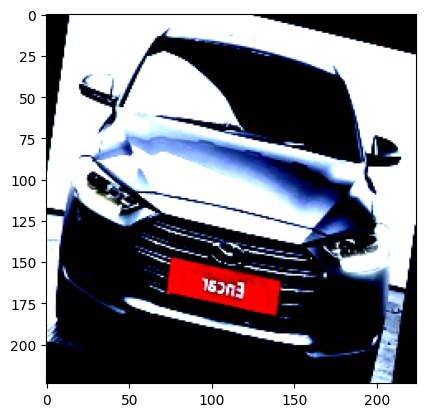

In [12]:
plt.imshow(images[5].permute(1,2,0))
plt.show()

### Model: CNN

In [ ]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [14]:
model = CarClassifierCNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [16]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_num, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {epoch_loss:.4f}")

        all_labels, all_predictions = validate_model(model, val_loader)

def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")

    return all_labels, all_predictions


train_model(model, criterion, optimizer, train_loader, val_loader, epochs=6)


Batch: 10, Epoch: 1/6, Loss: 1.7506
Batch: 20, Epoch: 1/6, Loss: 1.6481
Batch: 30, Epoch: 1/6, Loss: 1.5482
Batch: 40, Epoch: 1/6, Loss: 1.6264
Batch: 50, Epoch: 1/6, Loss: 1.4268
Epoch 1/6, Avg Loss: 1.6568
Validation Accuracy: 36.30%
Batch: 10, Epoch: 2/6, Loss: 1.4910
Batch: 20, Epoch: 2/6, Loss: 1.4062
Batch: 30, Epoch: 2/6, Loss: 1.3221
Batch: 40, Epoch: 2/6, Loss: 1.1927
Batch: 50, Epoch: 2/6, Loss: 1.4043
Epoch 2/6, Avg Loss: 1.4097
Validation Accuracy: 48.70%
Batch: 10, Epoch: 3/6, Loss: 1.2662
Batch: 20, Epoch: 3/6, Loss: 1.2196
Batch: 30, Epoch: 3/6, Loss: 1.3139
Batch: 40, Epoch: 3/6, Loss: 1.4015
Batch: 50, Epoch: 3/6, Loss: 1.2279
Epoch 3/6, Avg Loss: 1.2930
Validation Accuracy: 48.48%
Batch: 10, Epoch: 4/6, Loss: 1.1883
Batch: 20, Epoch: 4/6, Loss: 1.1506
Batch: 30, Epoch: 4/6, Loss: 1.2487
Batch: 40, Epoch: 4/6, Loss: 1.1339
Batch: 50, Epoch: 4/6, Loss: 1.1150
Epoch 4/6, Avg Loss: 1.2540
Validation Accuracy: 50.22%
Batch: 10, Epoch: 5/6, Loss: 1.2243
Batch: 20, Epoch: 5/

### Model 2: Transfer Learning with EfficientNet

In [20]:
import torchvision.models as models

class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights="DEFAULT")

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [23]:
model = CarClassifierEfficientNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003)

train_model(model, criterion, optimizer, train_loader, val_loader, epochs=7)

Batch: 10, Epoch: 1/7, Loss: 1.3469
Batch: 20, Epoch: 1/7, Loss: 1.2112
Batch: 30, Epoch: 1/7, Loss: 1.1043
Batch: 40, Epoch: 1/7, Loss: 1.1666
Batch: 50, Epoch: 1/7, Loss: 0.9481
Epoch 1/7, Avg Loss: 1.2116
Validation Accuracy: 62.17%
Batch: 10, Epoch: 2/7, Loss: 0.7162
Batch: 20, Epoch: 2/7, Loss: 1.1704
Batch: 30, Epoch: 2/7, Loss: 0.9402
Batch: 40, Epoch: 2/7, Loss: 1.2172
Batch: 50, Epoch: 2/7, Loss: 0.8126
Epoch 2/7, Avg Loss: 0.8795
Validation Accuracy: 69.13%
Batch: 10, Epoch: 3/7, Loss: 1.1093
Batch: 20, Epoch: 3/7, Loss: 0.6786
Batch: 30, Epoch: 3/7, Loss: 0.7929
Batch: 40, Epoch: 3/7, Loss: 0.7643
Batch: 50, Epoch: 3/7, Loss: 0.7002
Epoch 3/7, Avg Loss: 0.8216
Validation Accuracy: 66.30%
Batch: 10, Epoch: 4/7, Loss: 0.7669
Batch: 20, Epoch: 4/7, Loss: 0.6910
Batch: 30, Epoch: 4/7, Loss: 0.6211
Batch: 40, Epoch: 4/7, Loss: 0.4926
Batch: 50, Epoch: 4/7, Loss: 0.7211
Epoch 4/7, Avg Loss: 0.7853
Validation Accuracy: 66.74%
Batch: 10, Epoch: 5/7, Loss: 0.6225
Batch: 20, Epoch: 5/

### Model 3: Transfer Learning with EfficientNet b4

In [26]:
class CarClassifierEfficientNetb4(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b4(weights="DEFAULT")

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [27]:
model = CarClassifierEfficientNetb4(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003)

train_model(model, criterion, optimizer, train_loader, val_loader, epochs=7)

Batch: 10, Epoch: 1/7, Loss: 1.7208
Batch: 20, Epoch: 1/7, Loss: 1.3974
Batch: 30, Epoch: 1/7, Loss: 1.4916
Batch: 40, Epoch: 1/7, Loss: 1.3569
Batch: 50, Epoch: 1/7, Loss: 1.1278
Epoch 1/7, Avg Loss: 1.3889
Validation Accuracy: 61.30%
Batch: 10, Epoch: 2/7, Loss: 1.0695
Batch: 20, Epoch: 2/7, Loss: 1.0605
Batch: 30, Epoch: 2/7, Loss: 1.1061
Batch: 40, Epoch: 2/7, Loss: 1.3028
Batch: 50, Epoch: 2/7, Loss: 0.8564
Epoch 2/7, Avg Loss: 1.0449
Validation Accuracy: 59.35%
Batch: 10, Epoch: 3/7, Loss: 1.0755
Batch: 20, Epoch: 3/7, Loss: 0.9212
Batch: 30, Epoch: 3/7, Loss: 0.8871
Batch: 40, Epoch: 3/7, Loss: 1.0690
Batch: 50, Epoch: 3/7, Loss: 0.9242
Epoch 3/7, Avg Loss: 0.9441
Validation Accuracy: 62.17%
Batch: 10, Epoch: 4/7, Loss: 1.0982
Batch: 20, Epoch: 4/7, Loss: 0.8660
Batch: 30, Epoch: 4/7, Loss: 0.8975
Batch: 40, Epoch: 4/7, Loss: 0.9048
Batch: 50, Epoch: 4/7, Loss: 0.9761
Epoch 4/7, Avg Loss: 0.8893
Validation Accuracy: 64.78%
Batch: 10, Epoch: 5/7, Loss: 0.9814
Batch: 20, Epoch: 5/

### Model 3: Transfer Learning with Resnet 50

In [28]:
class CarClassifierResnet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.resnet50(weights="DEFAULT")

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [33]:
model = CarClassifierResnet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

train_model(model, criterion, optimizer, train_loader, val_loader, epochs=8)

Batch: 10, Epoch: 1/8, Loss: 0.8221
Batch: 20, Epoch: 1/8, Loss: 0.7815
Batch: 30, Epoch: 1/8, Loss: 0.6229
Batch: 40, Epoch: 1/8, Loss: 0.7602
Batch: 50, Epoch: 1/8, Loss: 0.7053
Epoch 1/8, Avg Loss: 0.8780
Validation Accuracy: 76.30%
Batch: 10, Epoch: 2/8, Loss: 0.4470
Batch: 20, Epoch: 2/8, Loss: 0.5734
Batch: 30, Epoch: 2/8, Loss: 0.4710
Batch: 40, Epoch: 2/8, Loss: 0.4874
Batch: 50, Epoch: 2/8, Loss: 0.2780
Epoch 2/8, Avg Loss: 0.4990
Validation Accuracy: 79.13%
Batch: 10, Epoch: 3/8, Loss: 0.2155
Batch: 20, Epoch: 3/8, Loss: 0.3441
Batch: 30, Epoch: 3/8, Loss: 0.1897
Batch: 40, Epoch: 3/8, Loss: 0.6277
Batch: 50, Epoch: 3/8, Loss: 0.3960
Epoch 3/8, Avg Loss: 0.3654
Validation Accuracy: 79.57%
Batch: 10, Epoch: 4/8, Loss: 0.4096
Batch: 20, Epoch: 4/8, Loss: 0.1191
Batch: 30, Epoch: 4/8, Loss: 0.1408
Batch: 40, Epoch: 4/8, Loss: 0.2304
Batch: 50, Epoch: 4/8, Loss: 0.2032
Epoch 4/8, Avg Loss: 0.2606
Validation Accuracy: 75.65%
Batch: 10, Epoch: 5/8, Loss: 0.0958
Batch: 20, Epoch: 5/

### Model Evaluation Using Confusion Matrix and Classification Report

In [44]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [45]:
from sklearn.metrics import classification_report

all_labels, all_predictions = validate_model(model, val_loader)

print(classification_report(all_labels, all_predictions, target_names=class_names))


Validation Accuracy: 79.78%
              precision    recall  f1-score   support

  F_Breakage       0.88      0.83      0.86       100
   F_Crushed       0.77      0.72      0.74        82
    F_Normal       0.82      0.92      0.87        89
  R_Breakage       0.71      0.86      0.78        64
   R_Crushed       0.72      0.70      0.71        66
    R_Normal       0.88      0.71      0.79        59

    accuracy                           0.80       460
   macro avg       0.80      0.79      0.79       460
weighted avg       0.80      0.80      0.80       460



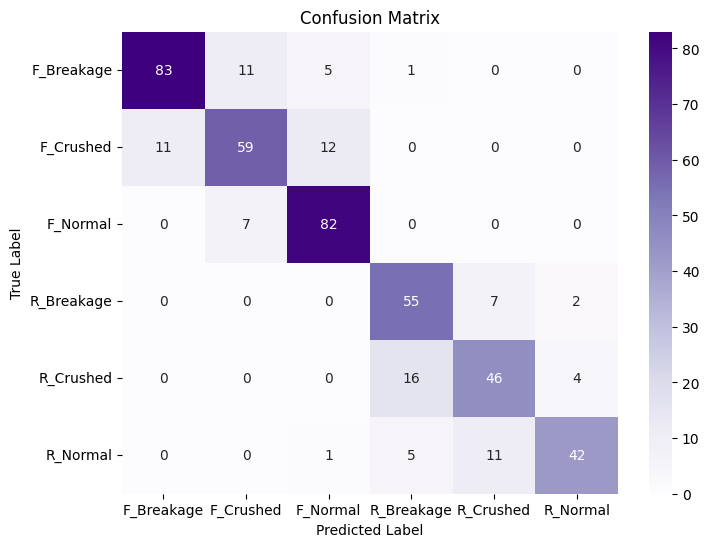

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### Saving the Final Resnet Model

In [47]:
torch.save(model.state_dict(),"Model_Resnet.pth")